In [1]:
%load_ext autoreload
%autoreload 2

# Counterfactual explanations for the GSMarena dataset

### Installations

Run the following cells to download the repository and install the required packages.

This is needed only on Google Colab, if you are running this notebook locally, you can skip this step.

In [2]:
COLAB_ENV = "google.colab" in str(get_ipython()) if hasattr(__builtins__, "__IPYTHON__") else False
print(f"Currently {'not ' if not COLAB_ENV else ''}running in a Colab environment")

Currently not running in a Colab environment


In [31]:
if COLAB_ENV:
    !mkdir my_repo
    !git clone https://github.com/Valendrew/counterfactual-explanations.git my_repo
    %cd my_repo
    !pip install -r requirements.txt -q

### Import of the libraries

In [6]:
from collections import Counter
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from utils.util_base_cf import inverse_pipeline
import utils.util_evaluation as util_evaluation

In [4]:
def set_default_randomness(seed: int):
    rng = np.random.RandomState(seed)
    return rng


SEED = 42
rng = set_default_randomness(SEED)

In [5]:
cols_pipeline = pickle.load(open("config/pipeline.pkl", "rb"))

kaggle.json not found, you cannot use kaggle module.


Unique values in the train dataset for discrete features

In [7]:
# df_train = pd.read_csv("data/model/gsm_train.csv", index_col=0)
# df_train_post = inverse_pipeline(cols_pipeline, df_train)

# discrete_features = df_train_post.columns.drop(["misc_price_min", "misc_price_max", "display_size", "battery"])
# print(f"Discrete features: {discrete_features.tolist()}")
# for c in discrete_features:
#     c_series = df_train_post[c].copy()
#     try:
#         c_series = c_series.astype(float)
#         c_series = c_series.round(2)
#     except ValueError:
#         c_series = c_series.astype(str)

#     print(f"'{c}' unique values: {np.sort(c_series.unique())}")

## Evaluation on correctly predicted samples

In this section we will analyze the performance of the counterfactual generation on samples that are correctly predicted by our model.

To compute the differences from the original samples, we need to import the dataframe with test data and we have to denormalize them.

In [24]:
df_test = pd.read_csv("data/model/gsm_test.csv", index_col=0)

df_test_den = inverse_pipeline(cols_pipeline, df_test)
# To avoid errors with different types
df_test_den = df_test_den.astype({"num_main_camera": float})

In the imported dataset we have some features that are not numbers, therefore we first have to do a simple remapping (like a LabelEncoding) from strings to the number that represents that text.

In [25]:
feat_str_dict = {
    "display_resolution": {
        "qHD": 0, "HD": 1, "FHD": 2, "QHD": 3
    },
    "network_technology": {
        "3G": 0, "4G": 1, "5G": 2
    }
}

price_map = {
    40: 0,
    215: 1,
    420: 2
}
# The name of the features used during training and for counterfactual generation
feature_columns = df_test_den.columns.drop(["misc_price_min", "misc_price_max"])

We also need to import the training data to compute some statistics and proceed with our analysis.

In [26]:
df_train = pd.read_csv("data/model/gsm_train.csv", index_col=0)
y_train = df_train.misc_price

# Denormalize the data and keep only necessary columns
df_train = inverse_pipeline(cols_pipeline, df_train)[feature_columns]

### OMLT

Read the counterfactuals generated by Omlt on the test set.

In [27]:
df_cf_omlt = pd.read_csv("data/counterfactual/multiclass.csv", index_col=0).drop('misc_price', axis=1)
df_cf_omlt.head()

,misc_price_min,misc_price_max,display_size,battery,memory_ram_gb,memory_rom_gb,main_camera_resolution,selfie_camera_resolution,display_resolution,network_technology,num_main_camera,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,has_wireless_charging,is_waterproof
664,215.0,420.0,6.37,2333.24,4.0,32.0,16.0,13.0,HD,4G,1.0,0,1,0,1,0,0,0,0
1228,215.0,420.0,6.09,2333.24,2.0,64.0,12.0,13.0,qHD,4G,1.0,1,1,0,1,0,0,0,0
1095,215.0,420.0,6.37,3436.45,2.0,16.0,12.0,4.0,HD,3G,1.0,1,1,0,1,0,0,0,0
584,215.0,420.0,4.95,2333.24,2.0,64.0,12.0,12.0,HD,4G,1.0,0,1,0,1,1,1,0,0
120,215.0,420.0,6.37,4118.63,2.0,16.0,12.0,4.0,HD,4G,2.0,1,1,0,1,0,0,0,1


At this point we merge the counterfactuals with the test dataset with an inner join and we set the features with the same value of the original sample to Nan. In this way we can quickly find all the features changed in the counterfactuals. 

In [43]:
merge_df_omlt = util_evaluation.join_merge_columns(df_cf_omlt, df_test_den)

Count the number of changed features in general.

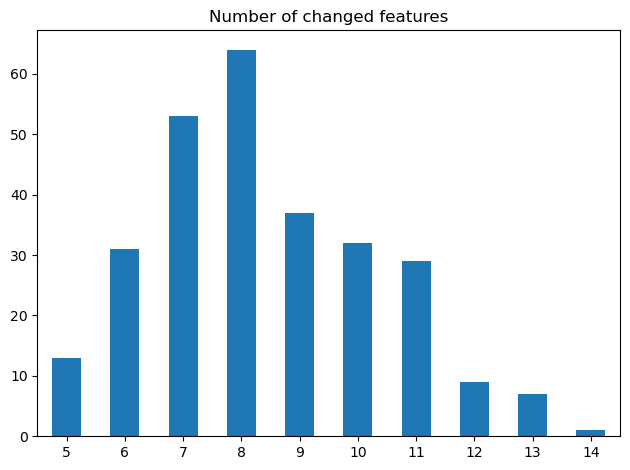

In [65]:
util_evaluation.plot_cfs_stats(
    merge_df_omlt, feature_columns, plot_mode="changed_feat", 
    plot_title="Number of changed features", split_ranges=False
)

We can already observe from this first chart that the number of features changed by Omlt, to generate a counterfactual, is quite high.

We want to further investigate how many features were changed when passing from a range of price to another, because ideally these values should be different. 

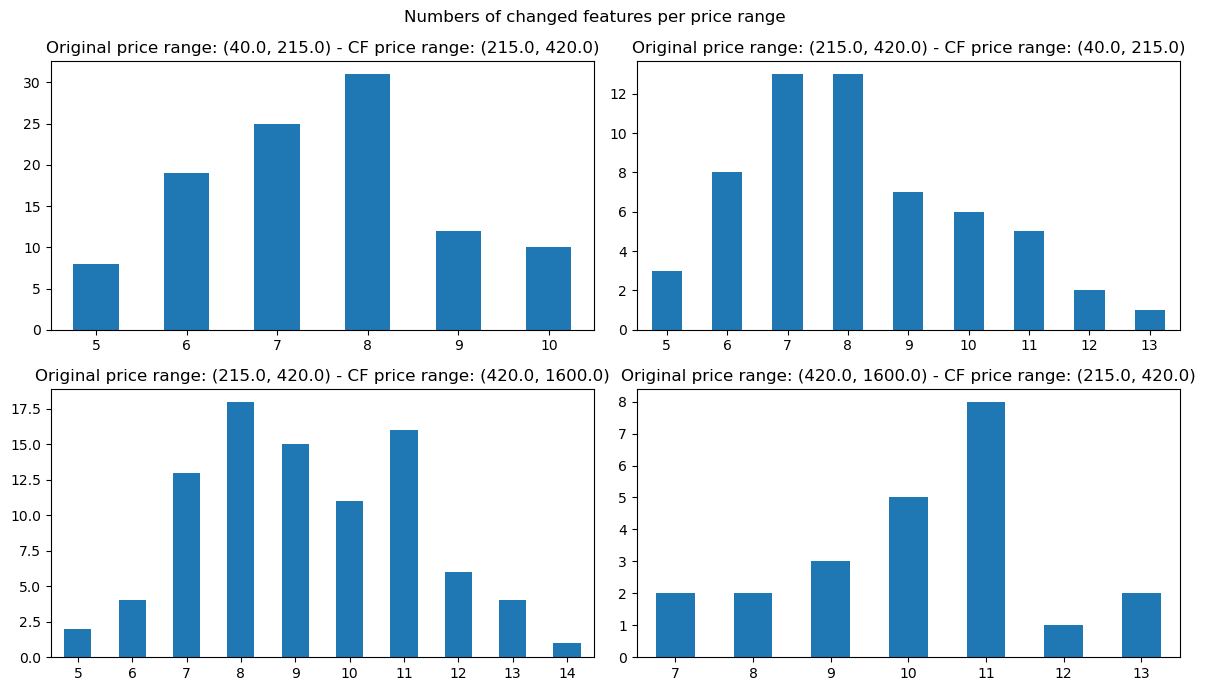

In [66]:
util_evaluation.plot_cfs_stats(
    merge_df_omlt, feature_columns=None, plot_mode="changed_feat", split_ranges=True,
    plot_title="Numbers of changed features per price range", figsize=(12,7)
)

As we can see from the subplots, passing from the low to the medium range seems to be the easiest change of label for Omlt. 

Another interesting chart that we can plot it's the one representing how many times each feature has been changed during the counterfactuals generation, such that we can discover which features are the most useful to change the price range of a device.

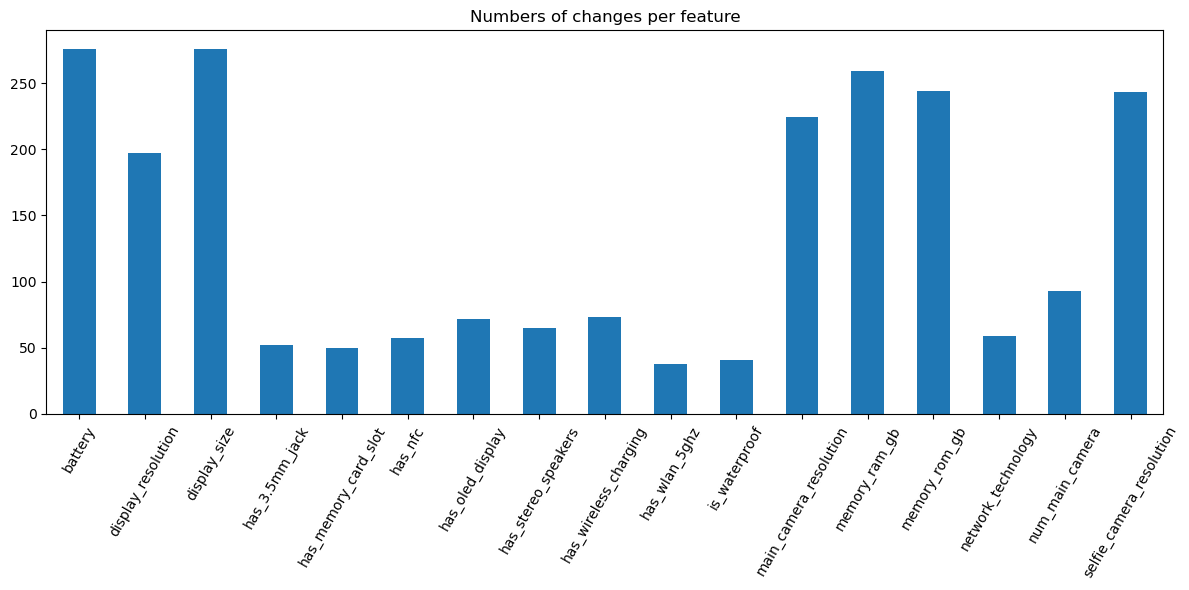

In [69]:
util_evaluation.plot_cfs_stats(
    merge_df_omlt, feature_columns, plot_mode="feat_count", split_ranges=False,
    plot_title="Numbers of changes per feature", figsize=(12, 6)
)

Also in this case we want to check if some features are more useful than others for changing the label from one price range to another.

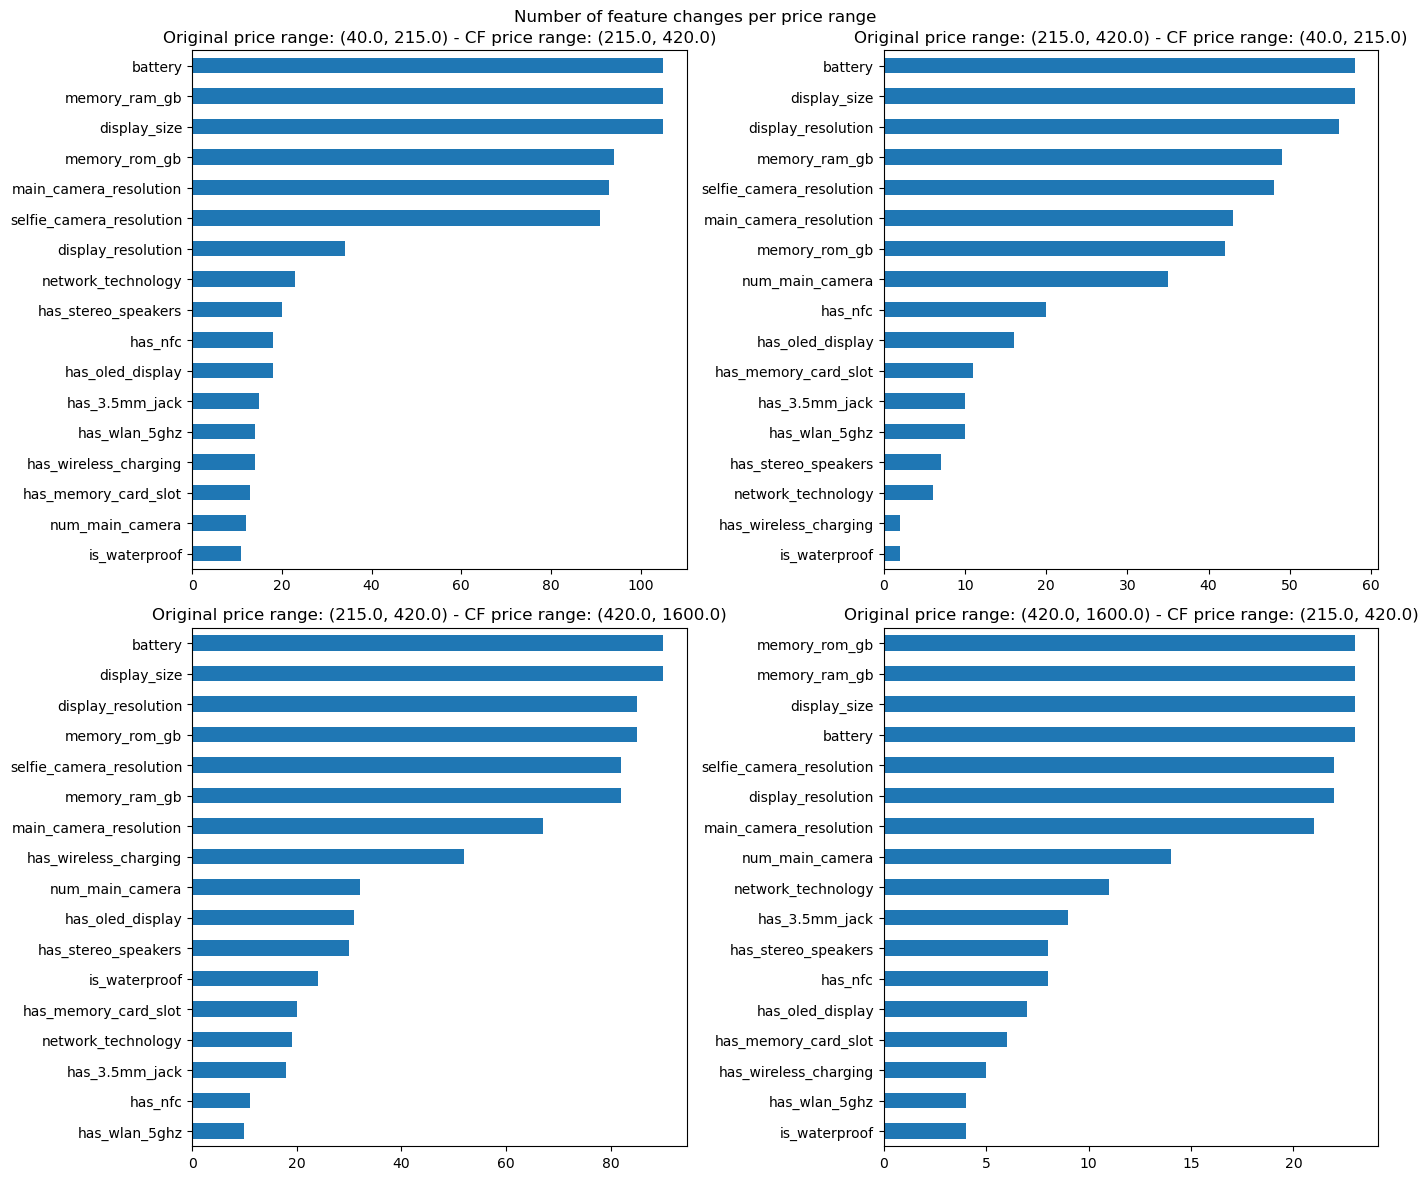

In [70]:
util_evaluation.plot_cfs_stats(
    merge_df_omlt, feature_columns, plot_mode="feat_count", split_ranges=True,
    plot_title="Number of feature changes per price range", figsize=(14, 12)
)

### Dice

In this other section we want to check how Dice generated the counterfactuals for the correctly predicted samples.

In [74]:
df_cf_dice = pd.read_csv("data/counterfactual/corr_cf_dice.csv", index_col=0)

# Cast types
df_cf_dice = util_evaluation.cast_round_type(df_cf_dice, df_test_den.dtypes.to_dict())
print(f"The dataframe has {df_cf_dice.shape[0]} rows.")

The dataframe has 372 rows.


As in the section before we compute the merge between the test dataframe and the one that contains the counterfactuals generated by Dice.

In [76]:
merge_df_dice = util_evaluation.join_merge_columns(df_cf_dice, df_test_den)

First of all we plot a generic chart that shows the number of changed features for the generated counterfactuals.

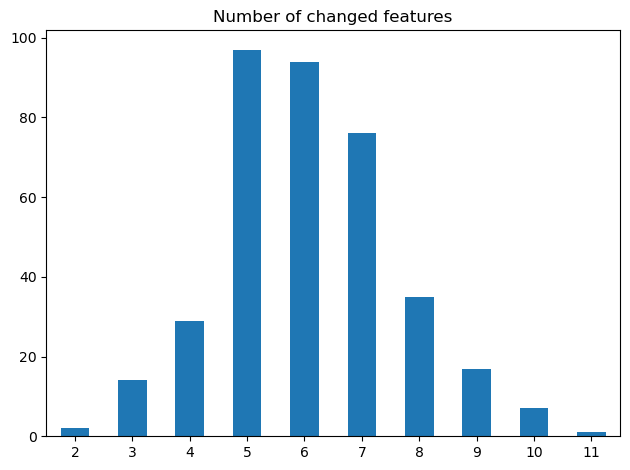

In [77]:
util_evaluation.plot_cfs_stats(
    merge_df_dice, feature_columns, plot_mode="changed_feat",
    plot_title="Number of changed features", split_ranges=False
)

Then we check if there are some ranges that are more difficult to change.

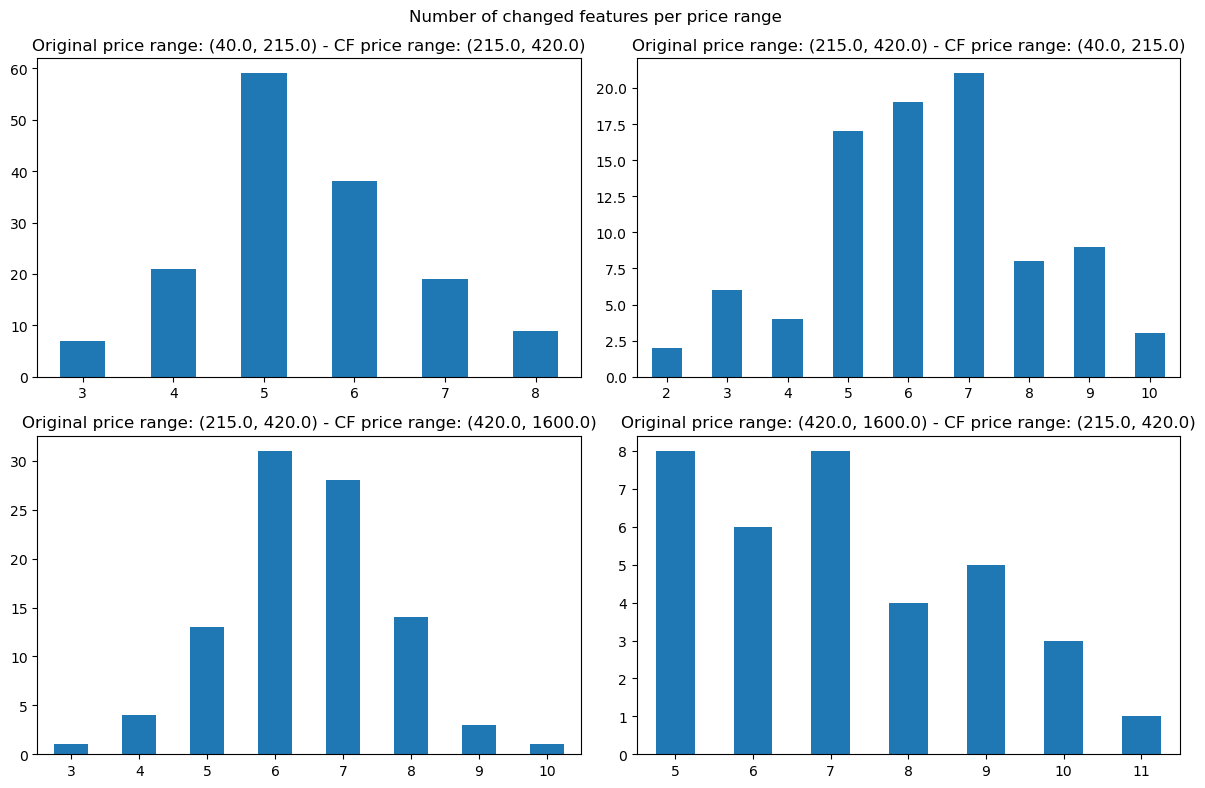

In [78]:
util_evaluation.plot_cfs_stats(
    merge_df_dice, feature_columns, plot_mode="changed_feat", split_ranges=True,
    plot_title="Number of changed features per price range", figsize=(12, 8)
)

We can notice that in general Dice can generate the counterfactuals changing less features than Omlt.

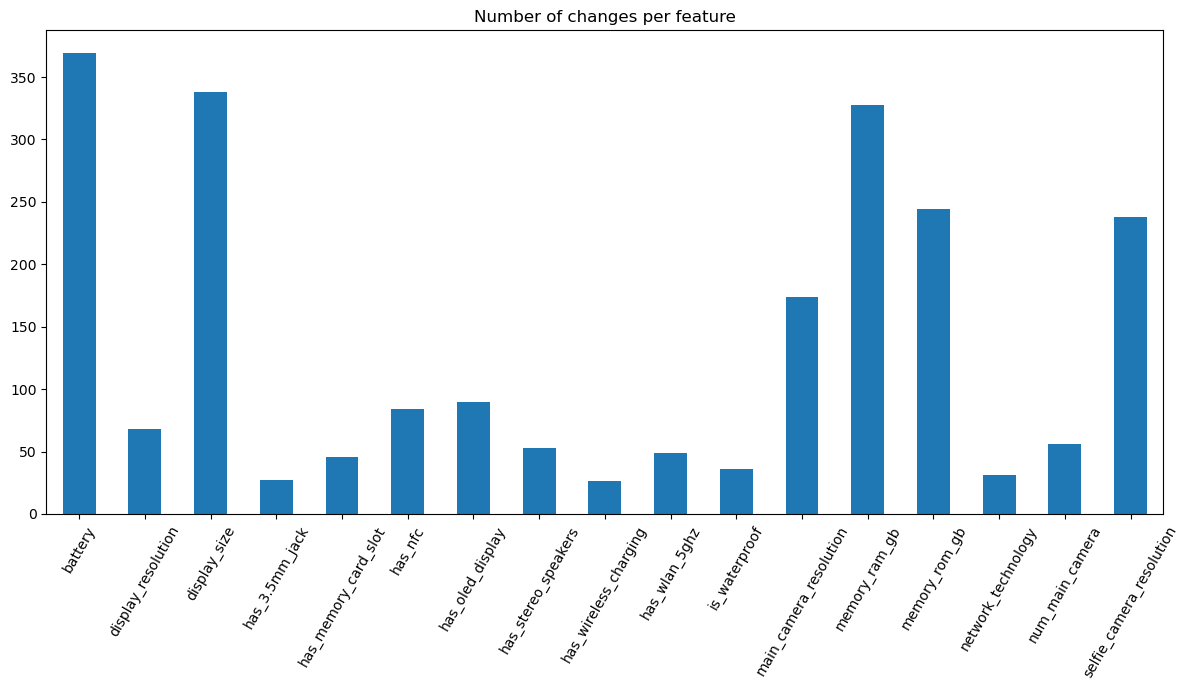

In [79]:
util_evaluation.plot_cfs_stats(
    merge_df_dice, feature_columns, plot_mode="feat_count", split_ranges=False,
    plot_title="Number of changes per feature", figsize=(12, 7)
)

Dice tends to change less frequently the 'display_resolution' feature, while Omlt seems to give more weight to it.

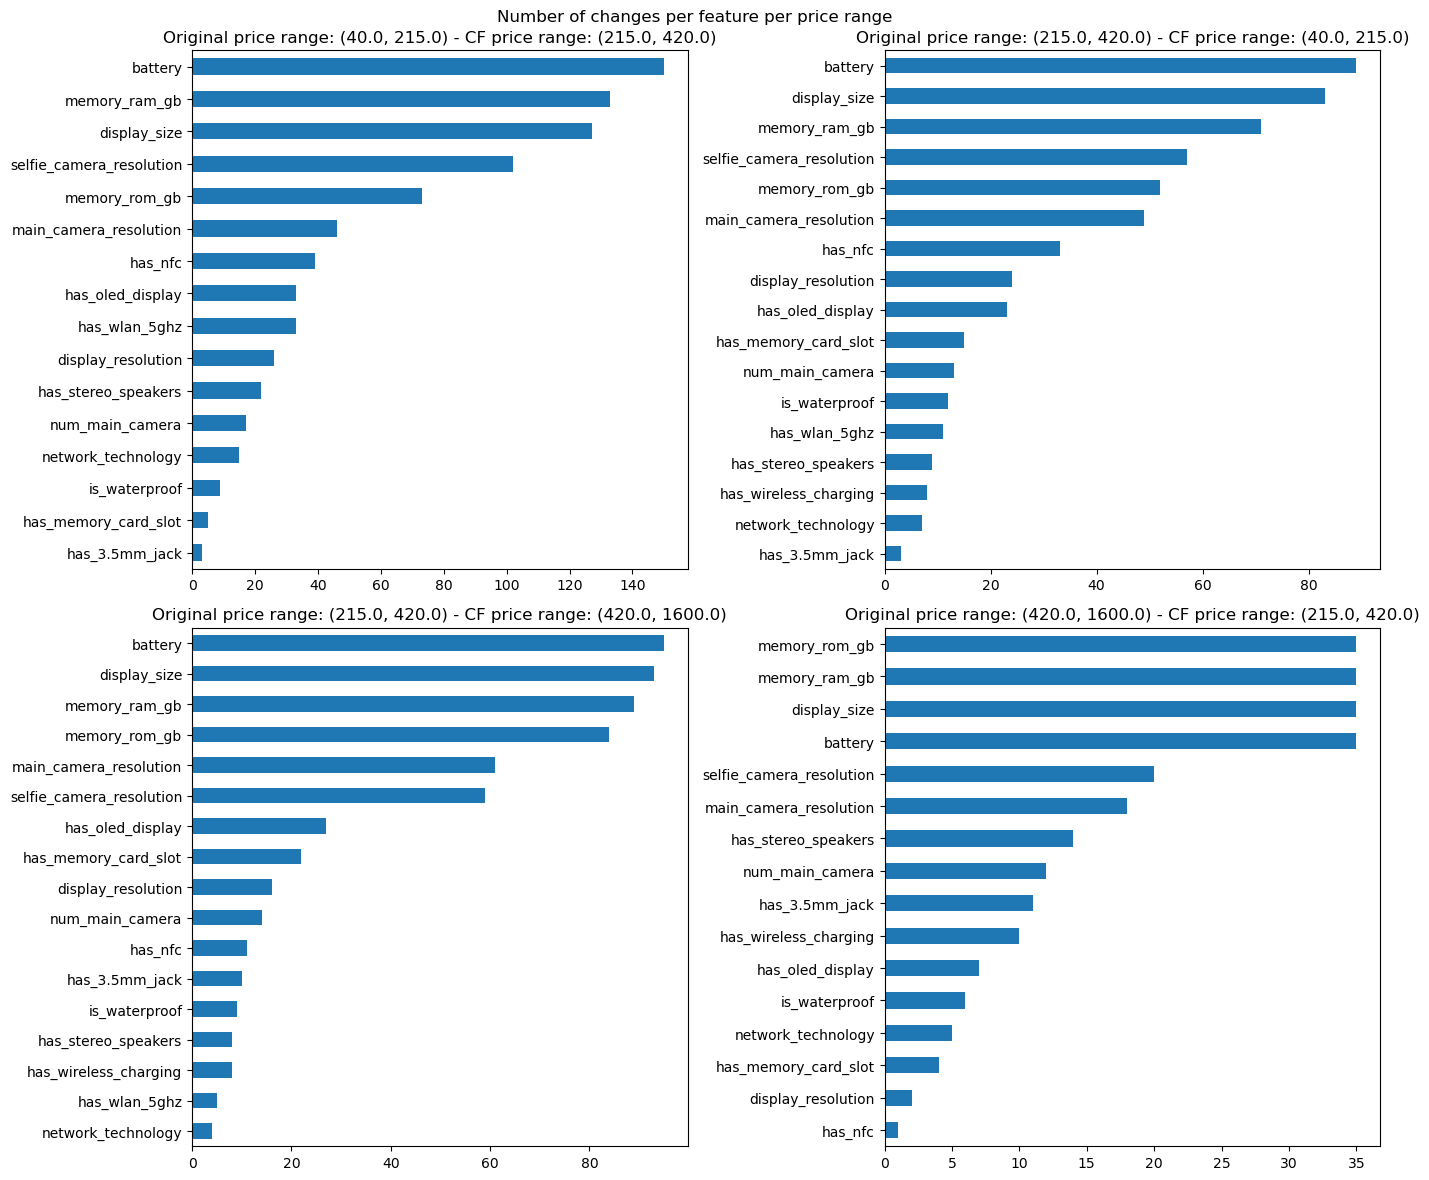

In [80]:
util_evaluation.plot_cfs_stats(
    merge_df_dice, feature_columns, plot_mode="feat_count", split_ranges=True,
    plot_title="Number of changes per feature per price range", figsize=(14, 12)
)

### Compute closest devices to the generated counterfactuals

Another important analysis may be to examine how much the generated counterfactuals are close to existent devices.

In [141]:
# Convert the strings to numbers and take only the useful columns
df_train = util_evaluation.convert_string_feat(df_train, feat_str_dict)
df_dice_comp = util_evaluation.convert_string_feat(df_cf_dice, feat_str_dict)

# Take the cf labels if we want to search only between sample with the same label
y_dice = df_dice_comp.misc_price_min.astype(int).replace(price_map)

# We can now remove the price ranges from Dice df
df_dice_comp = df_dice_comp[feature_columns]

In the following function we simply compute the most similar sample related to one cf, we can simply change the function to compute the most similar for each counterfactual, and check that the values is below a threshold.

In [223]:
def compute_most_similar_value(cfs, idx, df_train, y_train, y_dice, same_label=False):
    '''
    A function that computes the most similar sample to the one with
    index idx present in cfs.
    '''
    cf_idx = cfs.loc[[idx]]
    y_cf = y_dice.loc[[idx]]

    res = pd.DataFrame(columns=cf_idx.columns)
    # There can be multiple cfs
    for i in range(cf_idx.shape[0]):
        if same_label == True:
            search_index = df_train[y_train == y_cf.iloc[i]].index
        else:
            search_index = df_train.index

        diff_df = df_train.loc[search_index] - cf_idx.iloc[i]
        # Normalize
        norm_df = diff_df.apply(np.linalg.norm, ord=2, axis=1)
        most_sim_idx = norm_df.idxmin()

        if norm_df.loc[most_sim_idx] > 2:
            print(f"WARNING: the most similar sample for the cf {cf_idx.index} has a difference greater than the threshold.")
            
        res = pd.concat([res, df_train.loc[[norm_df.idxmin()]]], axis=0)

    return res

Let's see an example with the sample with index 314.

In [225]:
idx = 314
print("The considered counterfactual is:")
display(df_dice_comp.loc[[314]])
print("The most similar is:")
most_sim_df = compute_most_similar_value(df_dice_comp, idx, df_train, y_train, y_dice, same_label=True)
display(most_sim_df)

for i, sim_idx in enumerate(most_sim_df.index):
    print(f"The label of the counterfactual is {y_dice.loc[idx].iloc[i]}.")
    print(f"The label of the most similar sample is {y_train.loc[sim_idx]}\n")

The considered counterfactual is:


,display_size,battery,memory_ram_gb,memory_rom_gb,main_camera_resolution,selfie_camera_resolution,display_resolution,network_technology,num_main_camera,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,has_wireless_charging,is_waterproof
314,6.36,4000.0,3.0,32.0,17.0,13.0,2,1,2.0,0,1,0,1,1,0,0,0
314,6.28,3430.0,6.0,128.0,17.0,20.0,2,1,2.0,1,1,0,1,1,1,0,1


The most similar is:


,display_size,battery,memory_ram_gb,memory_rom_gb,main_camera_resolution,selfie_camera_resolution,display_resolution,network_technology,num_main_camera,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,has_wireless_charging,is_waterproof
357,6.36,4000.0,3.0,32.0,16.0,13.0,2,1,2.0,0,1,0,1,1,0,0,0
1203,6.28,3430.0,6.0,128.0,16.0,20.0,2,1,2.0,1,1,0,1,1,1,0,1


The label of the counterfactual is 0.
The label of the most similar sample is 0

The label of the counterfactual is 2.
The label of the most similar sample is 2



## Experiments with pgmpy

In [149]:
# Find the changed features and put 0 and 1
def find_changed_feat(data, df_test):
    orig = df_test.loc[data.name]
    
    return orig == data


res = df_cf_dice.apply(find_changed_feat, df_test=df_test_den, axis=1).astype(int)
res = res.drop(["misc_price_min", "misc_price_max"], axis=1)

res.to_csv("changed_features_dice.csv")

314
1861
1339
664
918
696
184
1549
1228
1098
1429
330
1076
645
1095
1031
1832
1109
1629
584
713
102
569
1010
114
120
1890
1337
1068
656
744
1310
914
1266
1534
897
125
69
1780
88
986
339
446
1360
1038
1205
1150
1516
141
535
218
1545
583
1002
1162
1741
214
1117
1585
777
1571
1668
489
1691
1735
1016
359
636
1383
1648
1006
778
418
754
1140
1120
978
1812
68
850
1509
289
1716
240
1104
932
618
304
801
210
785
1367
922
161
973
686
861
211
570
1042
1718
268
1079
329
1802
1572
1660
1040
119
615
1870
987
1425
800
1686
588
74
1023
1428
338
1394
309
501
87
1458
1341
767
1751
1745
542
862
1482
1771
855
1664
1053
746
1326
659
287
1773
545
1850
1406
462
1840
497
1654
1250
1865
944
1378
647
1066
1641
1073
1009
1215
1292
1245
194
508
1017
450
949
1253
1851
628
843
1889
1220
1743
1700
1452
333
1761
1580
271
400
1769
341
1237
1271
704
1151
762
1445
1035
1723
1265
133
485
105
1711
388
708
1845
116
1344
821
473
429
31
1899
33
1145
595
40
1335
1183
828
1072
1127
1562
1866
979
1290
839
1900
1258
1806
1291
174

In [166]:
import pgmpy as pg
from pgmpy.estimators import HillClimbSearch, BicScore, MmhcEstimator

In [154]:
from itertools import combinations

import networkx as nx
from sklearn.metrics import f1_score

In [168]:
est = HillClimbSearch(res)

bay_model = est.estimate(scoring_method=BicScore(res))

c:\Users\danie\miniconda3\envs\master-aiii\lib\site-packages\pgmpy\estimators\CITests.py:548: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for z_state, df in data.groupby(Z):
c:\Users\danie\miniconda3\envs\master-aiii\lib\site-packages\pgmpy\estimators\CITests.py:548: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for z_state, df in data.groupby(Z):
c:\Users\danie\miniconda3\envs\master-aiii\lib\site-packages\pgmpy\estimators\CITests.py:548: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid

KeyboardInterrupt: 

Text(0.5, 1.0, 'My Bayesian network')

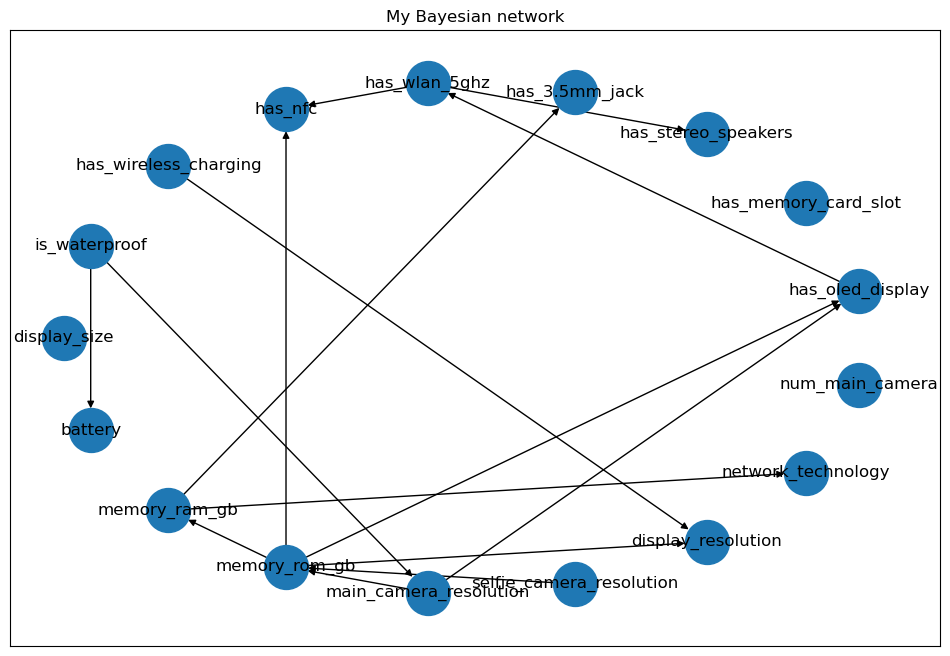

In [165]:
# Draw the network
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
nx.draw_networkx(bay_model, pos=nx.drawing.layout.shell_layout(bay_model), ax=ax, node_size=1000)
ax.set_title('My Bayesian network')